In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from random import shuffle
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode, read_image
from torch.utils.data import DataLoader, random_split
import random

In [34]:
forestDirectory = '../../pics/2750/Forest'
industrialDirectory = '../../pics/2750/Industrial'

In [35]:
dataset_path = "../../pics/2750/"
transform = ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)


In [36]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [37]:
idx = [i for i in range(len(dataset)) if (dataset.imgs[i][1] == dataset.class_to_idx['Industrial'] or dataset.imgs[i][1] == dataset.class_to_idx['Forest'])]
subset = torch.utils.data.Subset(dataset, idx)

In [38]:
# Define the train-validation split ratio (e.g., 0.8 for 80% training, 0.2 for 20% validation)
train_ratio = 0.8
train_size = int(train_ratio * len(subset))
val_size = len(subset) - train_size

In [39]:
# Verify that the sum of train_size and val_size is equal to the length of the dataset
if train_size + val_size != len(subset):
    raise ValueError("Sum of train_size and val_size does not equal the length of the dataset!")

In [40]:
# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(subset, [train_size, val_size])

In [41]:
# Create dataloaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [42]:
class_mapping = {'Industrial': 0, 'Forest': 1}

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(84, 2)  # Change the output size to 2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [48]:
# Initialize the CNN model
model = CNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs
num_epochs = 20

train_losses = []


In [50]:
# Training loop

# Create the class mapping dynamically
class_mapping = {class_name: i for i, class_name in enumerate(dataset.classes)}

# Update the number of output units in the last fully connected layer of the model
num_classes = len(class_mapping)
model.fc3 = nn.Linear(84, num_classes)

# Train dataset
train_dataset = [(image, class_mapping[dataset.classes[label]]) for image, label in train_dataset]

# Validation dataset
val_dataset = [(image, class_mapping[dataset.classes[label]]) for image, label in val_dataset]


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    print(f'Epochs: {epoch + 1:5d} | Loss: {epoch_loss:.4f}')

Epochs:     1 | Loss: 1.6920
Epochs:     2 | Loss: 0.6677
Epochs:     3 | Loss: 0.6356
Epochs:     4 | Loss: 0.6013
Epochs:     5 | Loss: 0.5129
Epochs:     6 | Loss: 0.2391
Epochs:     7 | Loss: 0.0384
Epochs:     8 | Loss: 0.0149
Epochs:     9 | Loss: 0.0094
Epochs:    10 | Loss: 0.0068
Epochs:    11 | Loss: 0.0056
Epochs:    12 | Loss: 0.0046
Epochs:    13 | Loss: 0.0040
Epochs:    14 | Loss: 0.0035
Epochs:    15 | Loss: 0.0031
Epochs:    16 | Loss: 0.0028
Epochs:    17 | Loss: 0.0026
Epochs:    18 | Loss: 0.0023
Epochs:    19 | Loss: 0.0021
Epochs:    20 | Loss: 0.0022


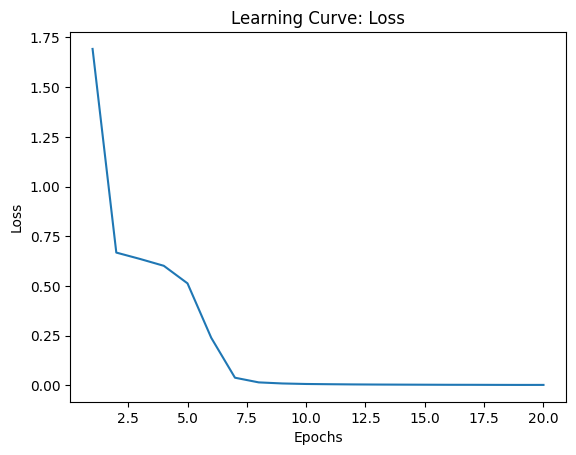

In [51]:
# Plot learning curve (loss)
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss')
plt.show()

In [53]:
# Evaluation on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9991
